# Retinal pyramid

## Initialization parameters

In [1]:
mode= 'bilinear' #resizing : continuous transition, reduces edges,contrast
width = 32 #side of the cropped image used to build the pyramid
base_levels = 1.61803
base_levels = 2 #downsampling/upsampling factor
n_sublevel = 2 #filters dictionnary, number of sublevels
n_azimuth = 12 #retinal transform characteristics 
n_theta = 12
n_phase = 2

N_batch = 4 #number of images 
pattern = 'i05june05_static_street_boston_*.jpeg'

## Libraries

In [2]:
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

In [3]:
import os

In [4]:
import torch
torch.set_default_tensor_type('torch.DoubleTensor')

In [5]:
%load_ext watermark
%watermark -i -h -m -v -p numpy,torch,POLO  -r -g -b

2020-03-03T12:18:14+01:00

CPython 3.7.6
IPython 7.13.0

numpy 1.18.1
torch 1.4.0
POLO not installed

compiler   : Clang 11.0.0 (clang-1100.0.33.16)
system     : Darwin
release    : 19.3.0
machine    : x86_64
processor  : i386
CPU cores  : 36
interpreter: 64bit
host name  : fortytwo
Git hash   : 216d8430c7b84d6a77f341fb8457107a2f259198
Git repo   : https://github.com/bicv/POLO/
Git branch : master


## Loading an image

In [6]:
%ls ../data #list of images stored in file data

800px-Fox_Hunt_1893_Winslow_Homer.jpg
homer.jpg
i05june05_static_street_boston_p1010764.jpeg*
i05june05_static_street_boston_p1010764.npy
i05june05_static_street_boston_p1010785.jpeg*
i05june05_static_street_boston_p1010800.jpeg*
i05june05_static_street_boston_p1010806.jpeg*
i05june05_static_street_boston_p1010808.jpeg*


In [7]:
from SLIP import imread

Tensor shape= torch.Size([1, 1, 768, 1024])


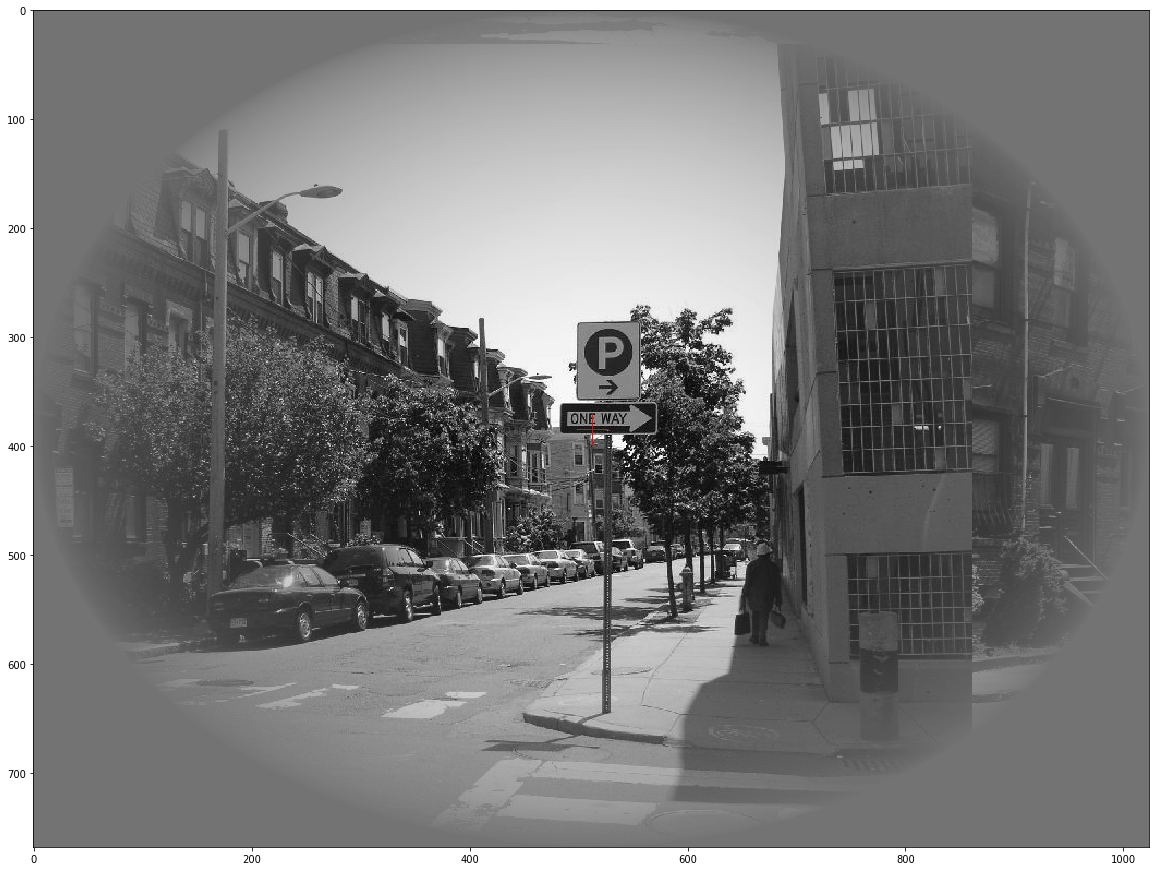

In [8]:
img_orig = imread('../data/i05june05_static_street_boston_p1010764.jpeg')
ds = 1
if ds>1: img_orig = img_orig[::ds, ::ds]
img_orig = np.roll(img_orig, -162//ds, axis=1) # sliding gaze to the right by moving image to the left
img_orig = np.roll(img_orig, 32//ds, axis=0) # sliding gaze to the top by moving image to the bottom

from SLIP import Image
N_X, N_Y = img_orig.shape
pe = {'N_X': N_X, 'N_Y': N_Y, 'do_mask': True} 

im = Image(pe) 
img_orig -= img_orig.mean() #substracting the image's mean to each element
img_orig *= im.mask #adding an oval mask  
img_tens = torch.Tensor(img_orig[None, None, ...]) 
print('Tensor shape=', img_tens.shape) #converting to a tensor format, image's size stored in img_tens.shape[-2:]

fig, ax = plt.subplots(figsize=(20,20))
ax.imshow(img_orig, cmap='gray')
ax.plot([img_orig.shape[1]/2], [img_orig.shape[0]/2], 'r+', ms=32);

# Using torch to build up a Laplacian pyramid


https://www.cs.tau.ac.il/~dcor/Graphics/Exercises/burt83laplacian.pdf

## Down-sampling recursively 

https://pytorch.org/docs/master/nn.functional.html#torch.nn.functional.interpolate


In [9]:
from torch.nn.functional import interpolate 

In [10]:
%%timeit
interpolate(img_tens, scale_factor=1/2, mode=mode) 

1.06 ms ± 14.5 µs per loop (mean ± std. dev. of 7 runs, 1000 loops each)


In [11]:
img_down = img_tens 
n_levels = 0
while max(img_down.shape[-2:]) > width : # until obtaining sides inferior to width (cf cropped image at each step) 
    n_levels += 1 
    print('Tensor shape=', img_down.shape, ', n_levels=', n_levels) #each iteration reduces the image's size by a factor defined by base_levels
    #print(np.log(img_down.shape[-2:])/np.log(base_levels)-np.log(width)/np.log(base_levels))
    img_down = interpolate(img_down, scale_factor=1/base_levels, mode=mode) # downsampling 1/base_levels (bilinear mode)
n_levels += 1
print('Top tensor shape=', img_down.shape, ', Final n_levels=', n_levels)

Tensor shape= torch.Size([1, 1, 768, 1024]) , n_levels= 1
Tensor shape= torch.Size([1, 1, 384, 512]) , n_levels= 2
Tensor shape= torch.Size([1, 1, 192, 256]) , n_levels= 3
Tensor shape= torch.Size([1, 1, 96, 128]) , n_levels= 4
Tensor shape= torch.Size([1, 1, 48, 64]) , n_levels= 5
Top tensor shape= torch.Size([1, 1, 24, 32]) , Final n_levels= 6


In [12]:
#Computing number of iterations to downsample the image to a size < width
n_levels = int(np.log(np.max(img_orig.shape)/width)/np.log(base_levels)) + 1 
print('Computed n_levels=', n_levels)

Computed n_levels= 6


Applying on the central crop of $32\times32$:

In [13]:
def cropped_pyramid(img_tens, width=width, base_levels=base_levels, verbose=False):
    
    N_batch, _, N_X, N_Y = img_tens.shape # tensor of the images  (dimension 4)
    n_levels = int(np.log(np.max((N_X, N_Y))/width)/np.log(base_levels)) + 1 #computing the number of iterations cf:downsampling
    
    img_crop = torch.zeros((N_batch, n_levels, width, width)) #creating the tensor to store the cropped images while pyramiding

    img_down = img_tens.clone()
    for i_level in range(n_levels-1): #each iteration -> residual_image = image - downsampled_cloned_image_reshaped_to_the_right_size 
        img_residual = img_down.clone()
        img_down = interpolate(img_down, scale_factor=1/base_levels, mode=mode) #downsampling
        img_residual -= interpolate(img_down, size=img_residual.shape[-2:], mode=mode)  #upsizing in order to substract

        if verbose: print('Tensor shape=', img_down.shape, ', shape=', img_residual.shape)
        h_res, w_res = img_residual.shape[-2:] #at each iteration the residual image size is reduced of a factor 1/base_levels (img_down the image downsampled at the previous iteration)

        img_crop[:, i_level, :, :] = img_residual[:, 0, 
                            (h_res//2-width//2):(h_res//2+width//2), 
                            (w_res//2-width//2):(w_res//2+width//2)] #the central crop of residual image stored in tensor img_crop

    h_res, w_res = img_down.shape[-2:]
    img_crop[:, n_levels-1, 
             (width//2-h_res//2):(width//2+h_res//2), 
             (width//2-w_res//2):(width//2+w_res//2)] = img_down[:, 0, :, :]
    if verbose: print('Top tensor shape=', img_down.shape, ', Final n_levels=', n_levels) #print image's dimensions after downsampling, condition max(img_down.shape[-2:])<=width satisfied
    return img_crop 

img_tens = torch.Tensor(img_orig[None, None, ...])
img_crop = cropped_pyramid(img_tens, verbose=True)

Tensor shape= torch.Size([1, 1, 384, 512]) , shape= torch.Size([1, 1, 768, 1024])
Tensor shape= torch.Size([1, 1, 192, 256]) , shape= torch.Size([1, 1, 384, 512])
Tensor shape= torch.Size([1, 1, 96, 128]) , shape= torch.Size([1, 1, 192, 256])
Tensor shape= torch.Size([1, 1, 48, 64]) , shape= torch.Size([1, 1, 96, 128])
Tensor shape= torch.Size([1, 1, 24, 32]) , shape= torch.Size([1, 1, 48, 64])
Top tensor shape= torch.Size([1, 1, 24, 32]) , Final n_levels= 6


Tensor shape= torch.Size([1, 6, 32, 32])


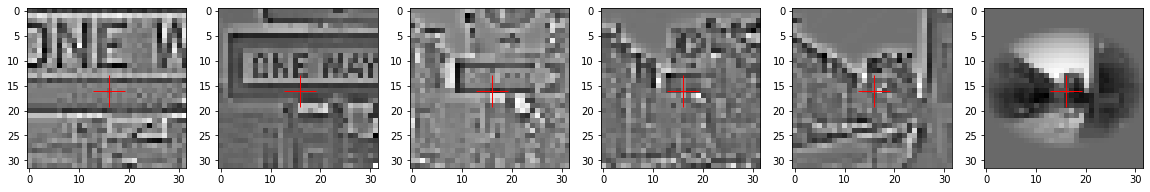

In [14]:
#displaying central crops from successive residual images
fig, axs = plt.subplots(1, n_levels, figsize=(20,20))
for i_level, ax in enumerate(axs):
    ax.imshow(img_crop.numpy()[0, i_level, ...], cmap='gray')
    ax.plot([width/2], [width/2], 'r+', ms=32);
print('Tensor shape=', img_crop.shape)  

# Creating a set of filters

## Log-Gabor filters:

documentation = https://nbviewer.jupyter.org/github/bicv/LogGabor/blob/master/LogGabor.ipynb


![Log-Gabor filters](https://camo.githubusercontent.com/867ab3c53cbeda20615518c722c60ec9071ee002/68747470733a2f2f6c617572656e7470657272696e65742e6769746875622e696f2f7075626c69636174696f6e2f666973636865722d30372d63762f66656174757265642e706e67)

In [15]:
from LogGabor import LogGabor
pe = {'N_X': width, 'N_Y': width, 'do_mask': False, 'base_levels':
          base_levels, 'n_theta': 24, 'B_sf': 0.6, 'B_theta': np.pi/12 ,
      'use_cache': True, 'figpath': 'results', 'edgefigpath':
          'results/edges', 'matpath': 'cache_dir', 'edgematpath':
          'cache_dir/edges', 'datapath': 'database/', 'ext': '.pdf', 'figsize':
          14.0, 'formats': ['pdf', 'png', 'jpg'], 'dpi': 450, 'verbose': 0}                 #log-Gabor parameters
lg = LogGabor(pe)
print('lg shape=', lg.pe.N_X, lg.pe.N_Y)

lg shape= 32 32


In [60]:
def local_filter(azimuth, theta, phase, sf_0=.25, B_theta=lg.pe.B_theta, radius=width/4):

    x, y = lg.pe.N_X//2, lg.pe.N_Y//2         # center
    x += radius * np.cos(azimuth)
    y += radius * np.sin(azimuth)
    
    return lg.normalize(lg.invert(
        lg.loggabor(x, y, sf_0=sf_0, B_sf=lg.pe.B_sf, theta=theta, B_theta=B_theta) * np.exp(-1j * phase)))

K = local_filter(azimuth=0, theta=0, phase=0, radius=width/4) 
print('K shape=', K.shape)
print('K min max=', K.min(), K.max())

K shape= (32, 32)
K min max= -0.4102999708906189 1.0


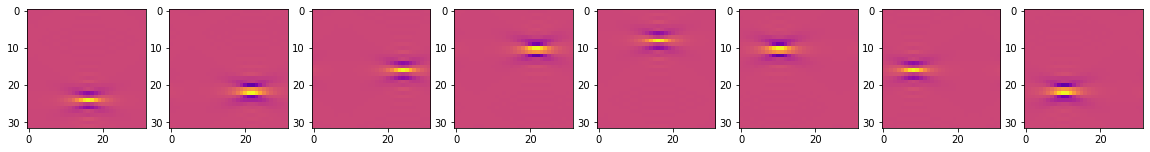

In [61]:
n_test = 8
fig, axs = plt.subplots(1, n_test, figsize=(20,20))
for i_azimuth, ax in enumerate(axs):
    ax.imshow(local_filter(azimuth=i_azimuth*2*np.pi/n_test, 
                           theta=0, phase=0), vmin=-1, vmax=1, cmap='plasma')


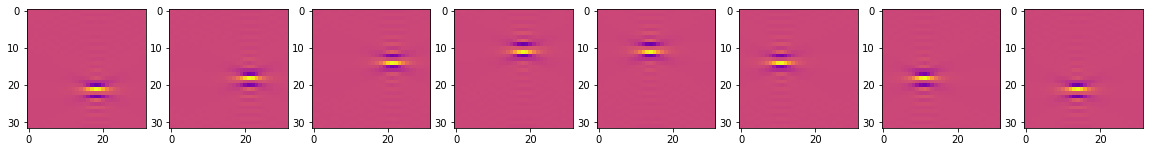

In [62]:
fig, axs = plt.subplots(1, n_test, figsize=(20,20))
for i_azimuth, ax in enumerate(axs):
    ax.imshow(local_filter(azimuth=(i_azimuth+.5)*2*np.pi/n_test, sf_0=.25*np.sqrt(2), 
                           theta=0, phase=0, radius=width/4/np.sqrt(2)), vmin=-1, vmax=1, cmap='plasma')


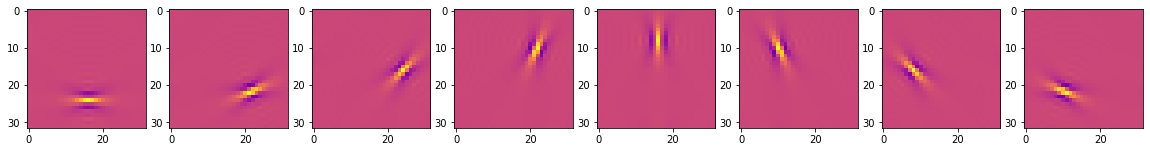

In [63]:
fig, axs = plt.subplots(1, n_test, figsize=(20,20))
for i_azimuth, ax in enumerate(axs):
    ax.imshow(local_filter(azimuth=i_azimuth*2*np.pi/n_test, 
                           theta=i_azimuth*np.pi/n_test, phase=0), vmin=-1, vmax=1, cmap='plasma')


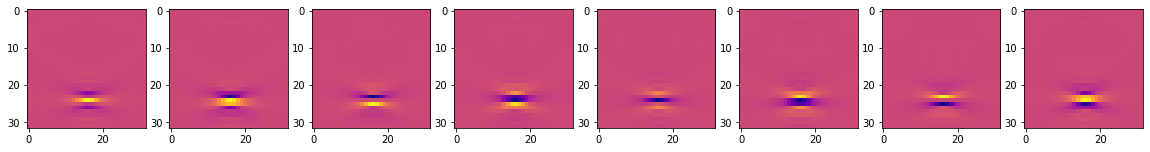

In [64]:
fig, axs = plt.subplots(1, n_test, figsize=(20,20))
for i_phase, ax in enumerate(axs):
    ax.imshow(local_filter(azimuth=0, theta=0, phase=i_phase*2*np.pi/n_test), vmin=-1, vmax=1, cmap='plasma')


In [17]:
def get_K(width=width, n_sublevel = n_sublevel, n_azimuth = n_azimuth, n_theta = n_theta, 
          n_phase = n_phase, r_min = width/6, r_max = width/3, log_density_ratio = 2, verbose=False): #filter tensor K definition using Di Carlo's formulas
    K = np.zeros((width, width, n_sublevel, n_azimuth, n_theta, n_phase))
    for i_sublevel in range(n_sublevel):
        sf_0 = .25*(np.sqrt(2)**i_sublevel)
        
        #radius = width/4/(np.sqrt(2)**i_sublevel)
        # Di Carlo / Retina Warp
        
        b = np.log(log_density_ratio)  / (r_max - r_min)
        a = (r_max - r_min) / (np.exp (b * (r_max - r_min)) - 1)
        r_ref = r_min + i_sublevel * (r_max - r_min) / n_sublevel
        r_prim =  a * np.exp(b * (r_ref - r_min))
        radius =  r_prim
        d_r_prim = a * b * np.exp(b * (r_ref - r_min))
        p_ref = 4 * width / 32 
        p_loc = p_ref * d_r_prim
        sf_0 = 1 / p_loc
        if verbose: print('i_sublevel, sf_0, radius', i_sublevel, sf_0, radius)
        for i_azimuth in range(n_azimuth):
            for i_theta in range(n_theta):
                for i_phase in range(n_phase):
                    azimuth = (i_azimuth+i_sublevel/2)*2*np.pi/n_azimuth
                    K[..., i_sublevel, i_azimuth, i_theta, i_phase] = local_filter(azimuth=azimuth,
                                                                                   theta=i_theta*np.pi/n_theta + azimuth, 
                                                                                   phase=i_phase*np.pi/n_phase, sf_0=sf_0, radius=radius)
    K = torch.Tensor(K)

    if verbose: print('K shape=', K.shape)
    if verbose: print('K min max=', K.min(), K.max())

    return K
K = get_K(verbose=True)

i_sublevel, sf_0, radius 0 0.3606737602222408 5.333333333333333
i_sublevel, sf_0, radius 1 0.2550348616491973 7.542472332656507
K shape= torch.Size([32, 32, 2, 12, 12, 2])
K min max= tensor(-1.) tensor(1.)


DONE: add visualization of filters from ``2020-02-10_retina_reconstruction``

## Visual field covering

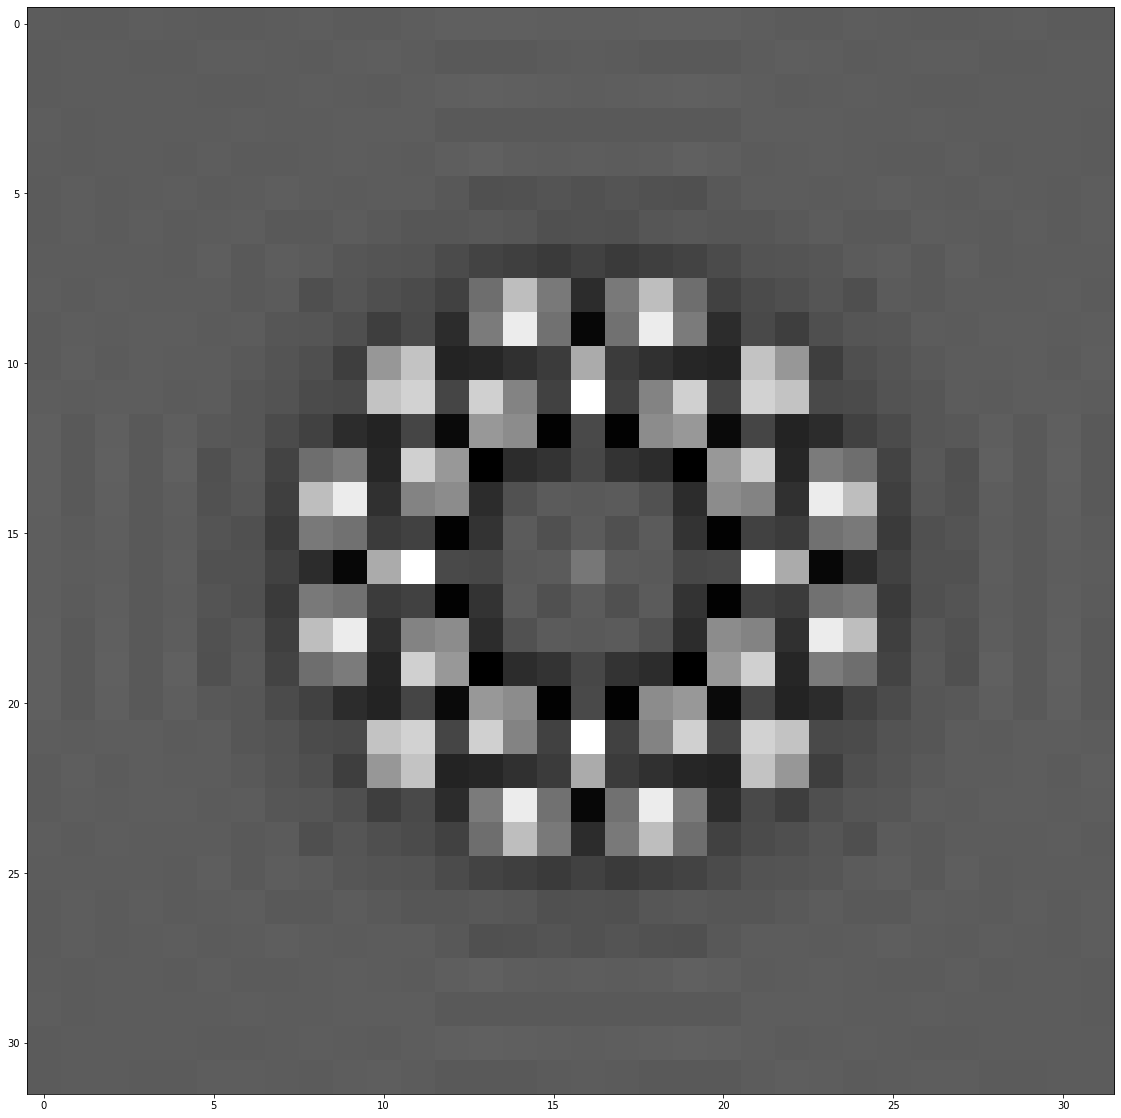

In [18]:
coefs = np.zeros((n_sublevel, n_azimuth, n_theta, n_phase))  #creating an array of zeros
coefs[:, :, :, 0] = np.ones((n_sublevel, n_azimuth, n_theta)) 
coefs_tf = torch.Tensor(coefs)
img_dis = torch.tensordot(K, coefs_tf, dims=4) #tensor product -> filters location on the image
fig, ax = plt.subplots(1, 1, figsize=(20,20))
ax.imshow(img_dis.numpy()[:, :, ...], cmap='gray');

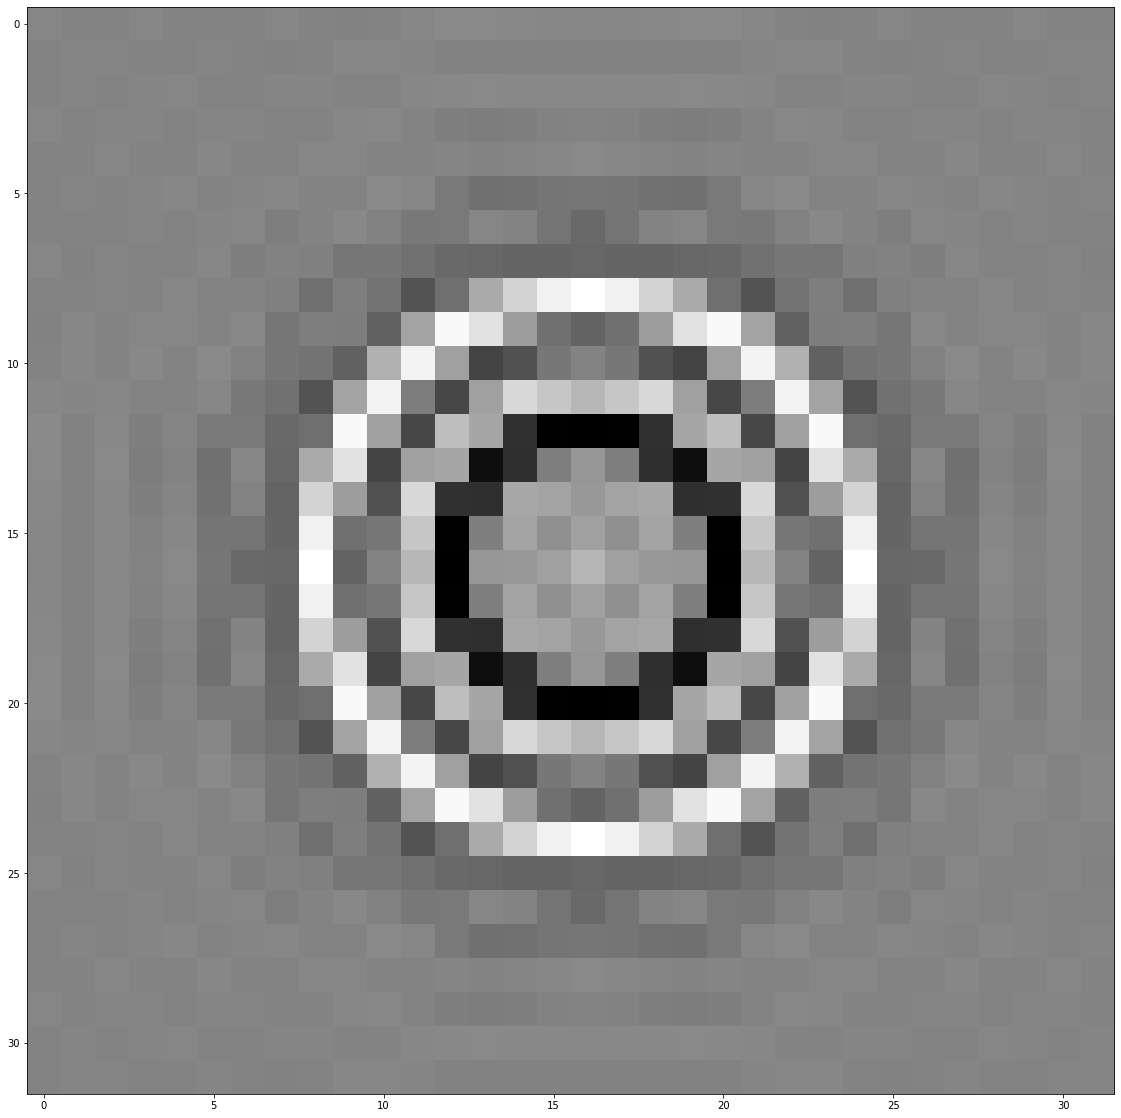

In [19]:
coefs = np.zeros((n_sublevel, n_azimuth, n_theta, n_phase))  #creating an array of zeros
coefs[:, :, 0, 0] = np.ones((n_sublevel, n_azimuth)) 
coefs_tf = torch.Tensor(coefs)
img_dis = torch.tensordot(K, coefs_tf, dims=4) #tensor product -> filters location on the image
fig, ax = plt.subplots(1, 1, figsize=(20,20))
ax.imshow(img_dis.numpy()[:, :, ...], cmap='gray');

In [20]:
print( f'n_levels = {n_levels}')


n_levels = 6


In [21]:
print( f'initial number of pixels = {N_X * N_Y}')

initial number of pixels = 786432


In [22]:
print( f'initial number of filters = {n_levels*n_sublevel*n_azimuth*n_theta*n_phase}')

initial number of filters = 3456


In [23]:
print( f'Compression rate = {(1 - n_levels*n_sublevel*n_azimuth*n_theta*n_phase / N_X / N_Y )*100:.3f} %')

Compression rate = 99.561 %


In [24]:
print( f'Acc map output = {n_levels*n_sublevel*n_azimuth}')

Acc map output = 144


## Applying the filter

In [25]:
print('Tensor shape=', img_crop.shape) #cropped image tensor shape

Tensor shape= torch.Size([1, 6, 32, 32])


In [26]:
%%timeit
out = torch.tensordot(img_crop, K,  dims=2) # applying K filters to the cropped image (convolution)

52.8 µs ± 2.38 µs per loop (mean ± std. dev. of 7 runs, 10000 loops each)


In [27]:
out = torch.tensordot(img_crop, K,  dims=2) #cropped image tensor shape after the convolution
print('Tensor shape=', out.shape)

Tensor shape= torch.Size([1, 6, 2, 12, 12, 2])


# Reconstruction

## Layer by layer from cropped central images

Tensor shape= torch.Size([1, 6, 32, 32])


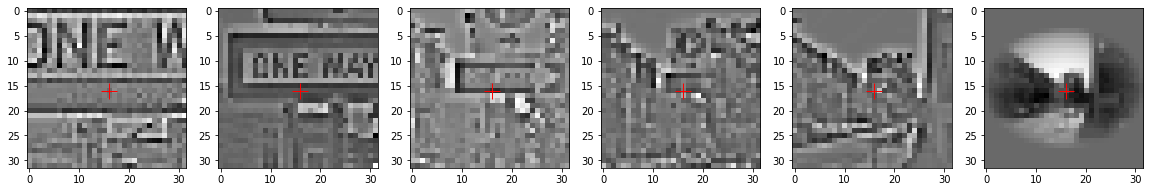

In [28]:
#displaying central crops from successive residual images (cf pyramid)
fig, axs = plt.subplots(1, n_levels, figsize=(20,20)) 
for i_level, ax in enumerate(axs):
    ax.imshow(img_crop.numpy()[0, i_level, ...], cmap='gray')
    ax.plot([width/2], [width/2], 'r+', ms=16);
print('Tensor shape=', img_crop.shape)  

In [29]:
print('Filter tensor shape=', K.shape) 
K_ = K.reshape((width**2, n_sublevel*n_azimuth*n_theta*n_phase))
print('Reshaped filter tensor=', K_.shape)

Filter tensor shape= torch.Size([32, 32, 2, 12, 12, 2])
Reshaped filter tensor= torch.Size([1024, 576])


In [30]:
print('Tensor shape=', out.shape) #cropped image tensor shape after the convolution
out__ = out.reshape((1, n_levels, n_sublevel*n_azimuth*n_theta*n_phase))
print('Tensor shape=', out__.shape)

Tensor shape= torch.Size([1, 6, 2, 12, 12, 2])
Tensor shape= torch.Size([1, 6, 576])


In [31]:
K_inv = torch.pinverse(K_) #inversing K filters
print('Tensor shape=', K_inv.shape)

Tensor shape= torch.Size([576, 1024])


In [32]:
img_rec =  torch.tensordot(out__, K_inv,  dims=1).reshape((1, n_levels, width, width)) 
print('Tensor shape=', img_rec.shape)

Tensor shape= torch.Size([1, 6, 32, 32])


Tensor shape= torch.Size([1, 6, 32, 32])


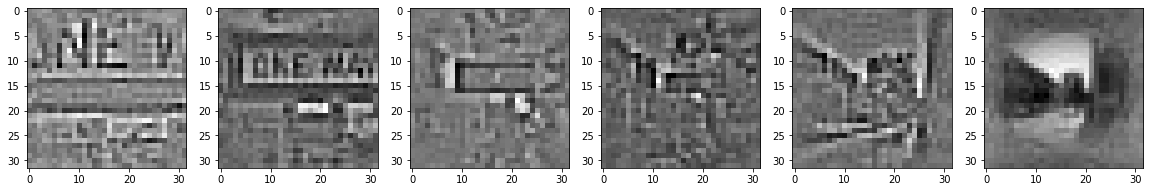

In [33]:
fig, axs = plt.subplots(1, n_levels, figsize=(20,20)) #reconstructing cropped images from the pyramid
for i_level, ax in enumerate(axs):
    ax.imshow(img_rec.numpy()[0, i_level, ...], cmap='gray')
print('Tensor shape=', img_crop.shape)

## Inverse pyramid from the coefficients

In [34]:
def inverse_pyramid(out, K, N_X=N_X, N_Y=N_Y, base_levels=base_levels, verbose=False):
    N_batch = out.shape[0] 
    width =  K.shape[0]
    n_levels = int(np.log(np.max((N_X, N_Y))/width)/np.log(base_levels)) + 1
    n_sublevel, n_azimuth, n_theta, n_phase = K.shape[2:]
    
    out__ = out.reshape((N_batch, n_levels, n_sublevel*n_azimuth*n_theta*n_phase))
    K_ = K.reshape((width**2, n_sublevel*n_azimuth*n_theta*n_phase))
    K_inv = torch.pinverse(K_)
    img_crop_rec =  torch.tensordot(out__, K_inv,  dims=1).reshape((N_batch, n_levels, width, width))

    img_rec = img_crop_rec[:, -1, :, :].unsqueeze(1)
    for i_level in range(n_levels-1)[::-1]: # from the top to the bottom of the pyramid
        img_rec = interpolate(img_rec, scale_factor=base_levels, mode=mode) #upsampling (factor=base_levels)
        h_res, w_res = img_rec.shape[-2:]
        img_rec[:, 0, (h_res//2-width//2):(h_res//2+width//2), (w_res//2-width//2):(w_res//2+width//2)] += img_crop_rec[:, i_level, :, :] #adding previous central crop to img_crop 
    img_rec = img_rec[:, :, (h_res//2-N_X//2):(h_res//2+N_X//2), (w_res//2-N_Y//2):(w_res//2+N_Y//2)]

    return img_rec

img_rec = inverse_pyramid(out, K)

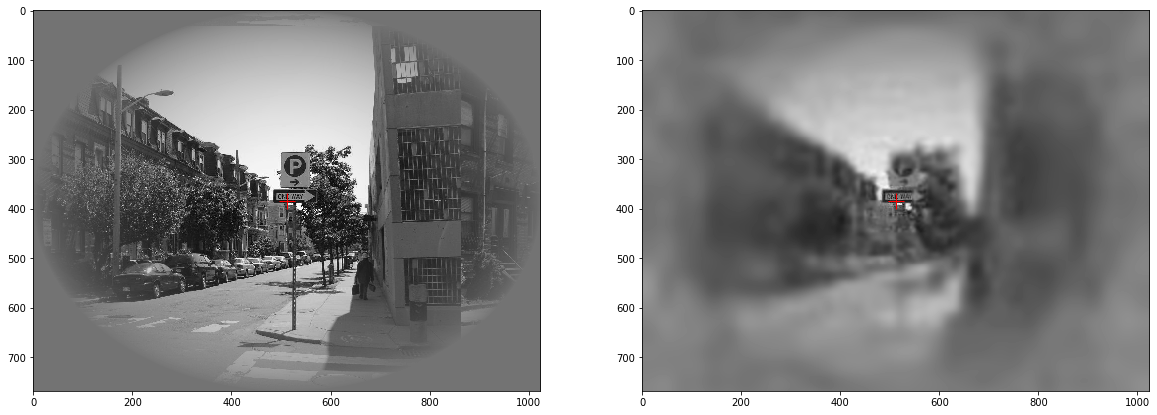

In [35]:
#Plotting reconstructed image
fig, axs = plt.subplots(1, 2, figsize=(20,20))
for ax, img in zip(axs, [img_tens, img_rec.detach()]):
    ax.imshow(img[0, 0, :, :].numpy(), cmap='gray')
    ax.plot([N_Y//2], [N_X//2], 'r+', ms=16); #central cross

# Optimizing the reconstruction

## Defining a dataloader

In [51]:
def get_dataloader(K, N_batch, pattern=pattern, 
                   ds=ds, saccade_radius=.15, verbose=False):
    from glob import glob
    imgs = []
    for fname in glob(os.path.join('../data', pattern)):
        img_orig = imread(fname)
        if ds>1: img_orig = img_orig[::ds, ::ds]
        from SLIP import Image
        pe = {'N_X': img_orig.shape[0], 'N_Y': img_orig.shape[1], 'do_mask': True}
        im = Image(pe)
        imgs.append(img_orig)
                          
    N_imgs = len(imgs)
    if verbose: print('N_imgs ', N_imgs )
    N_X, N_Y = img_orig.shape
    width = K.shape[0]
    #n_levels = int(np.log(np.max((N_X, N_Y))/width)/np.log(base_levels)) + 1

    target = torch.zeros((N_batch, 1, N_X, N_Y))
    for i in range(N_batch):
        # generate random saccades
        target_ = imgs[int(N_imgs*np.random.rand())].copy()
        sacc_x, sacc_y = np.int(saccade_radius*N_X*np.random.rand()), np.int(saccade_radius*N_Y*np.random.rand())
        if verbose: print('sacc_x, sacc_y ', sacc_x, sacc_y )
        target_ = np.roll(target_, sacc_y, axis=1)
        target_ = np.roll(target_, sacc_x, axis=0) 
        target[i, :, :, :] = torch.from_numpy(target_[None, :, :])

    if verbose: print(target.shape)
    img_crop = cropped_pyramid(target, verbose=verbose)
    if verbose: print(img_crop.shape)
    out = torch.tensordot(img_crop, K, dims=2)

    from torch.utils.data import TensorDataset, DataLoader
    dataloader = DataLoader(TensorDataset(target, out), batch_size=N_batch, shuffle=False, drop_last=False)
    return dataloader

dataloader = get_dataloader(K, N_batch, verbose=True)

N_imgs  5
sacc_x, sacc_y  103 121
sacc_x, sacc_y  88 58
sacc_x, sacc_y  112 86
sacc_x, sacc_y  3 51
sacc_x, sacc_y  90 1
sacc_x, sacc_y  78 85
sacc_x, sacc_y  53 73
sacc_x, sacc_y  70 118
sacc_x, sacc_y  55 143
sacc_x, sacc_y  23 82
sacc_x, sacc_y  54 71
sacc_x, sacc_y  113 31
sacc_x, sacc_y  51 124
sacc_x, sacc_y  99 91
sacc_x, sacc_y  30 109
sacc_x, sacc_y  40 131
sacc_x, sacc_y  36 109
sacc_x, sacc_y  13 143
sacc_x, sacc_y  32 89
sacc_x, sacc_y  57 15
sacc_x, sacc_y  20 139
sacc_x, sacc_y  18 51
sacc_x, sacc_y  46 93
sacc_x, sacc_y  46 100
sacc_x, sacc_y  41 22
sacc_x, sacc_y  29 104
sacc_x, sacc_y  102 15
sacc_x, sacc_y  29 25
sacc_x, sacc_y  45 81
sacc_x, sacc_y  92 91
sacc_x, sacc_y  12 136
sacc_x, sacc_y  94 78
sacc_x, sacc_y  82 50
sacc_x, sacc_y  92 95
sacc_x, sacc_y  100 124
sacc_x, sacc_y  51 26
sacc_x, sacc_y  80 30
sacc_x, sacc_y  112 44
sacc_x, sacc_y  48 149
sacc_x, sacc_y  69 100
sacc_x, sacc_y  108 23
sacc_x, sacc_y  93 62
sacc_x, sacc_y  22 6
sacc_x, sacc_y  0 83
sacc

## Validating the test set

In [52]:
test_dataloader = get_dataloader(K, N_batch, verbose=False)
for batch_idx, (target, out) in enumerate(test_dataloader):
    print(batch_idx, target.shape, out.shape)

0 torch.Size([128, 1, 768, 1024]) torch.Size([128, 6, 2, 12, 12, 2])


In [53]:
img_rec = inverse_pyramid(out, K)
print('img_rec.shape', img_rec.shape)

img_rec.shape torch.Size([128, 1, 768, 1024])


In [54]:
N_batch = 4

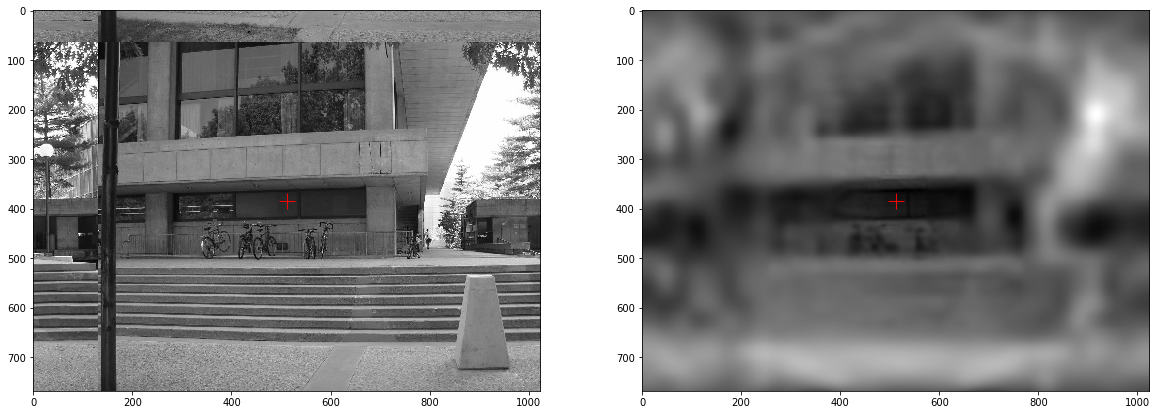

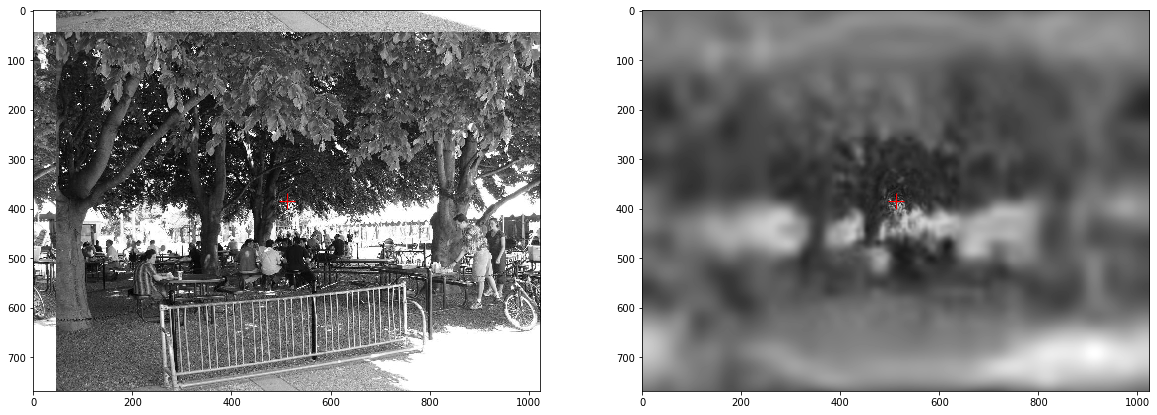

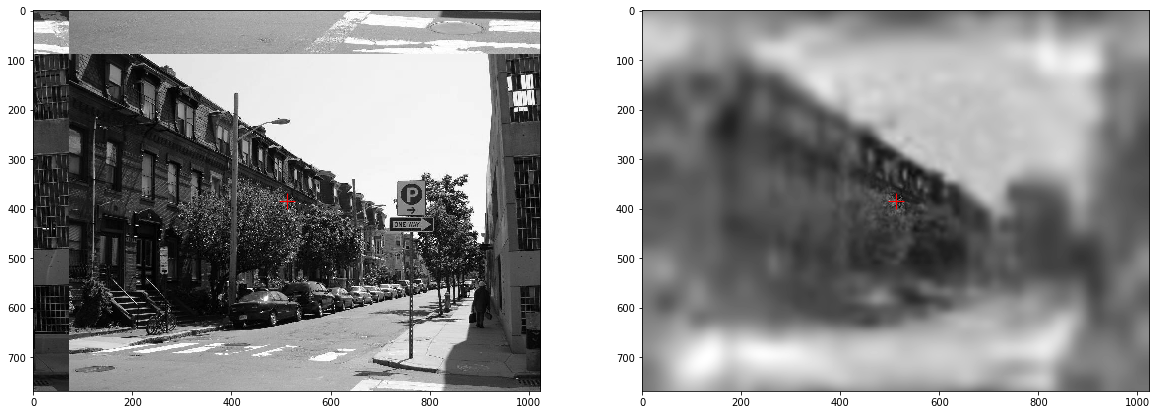

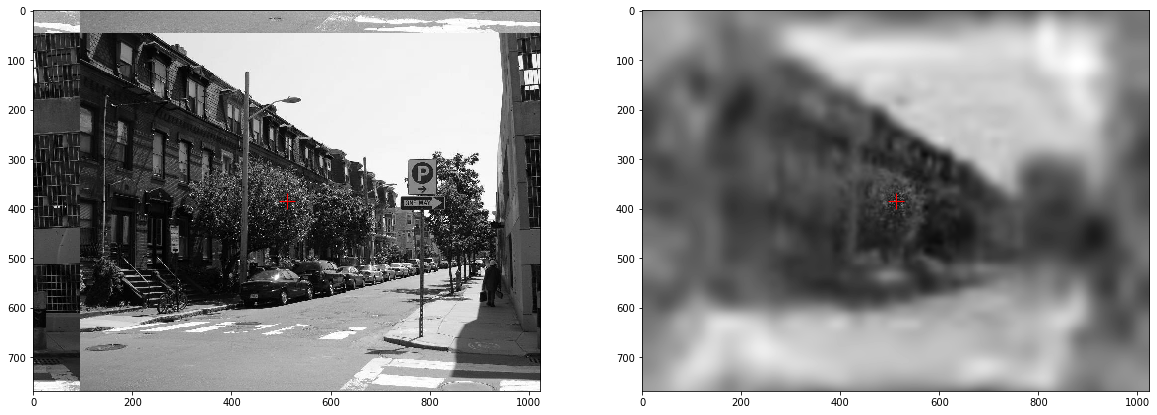

In [55]:
for i_batch in range(N_batch): #applying the pyramid and reconstruction to a batch of images
    fig, axs = plt.subplots(1, 2, figsize=(20, 20))
    for ax, img in zip(axs, [target[i_batch, 0, :, :], img_rec[i_batch, 0, :, :]]):
        ax.imshow(img.numpy(), cmap='gray')
        ax.plot([N_Y//2], [N_X//2], 'r+', ms=16);


## Testing different parameters

In [56]:
K = get_K(n_azimuth = 9)

In [57]:
test_dataloader = get_dataloader(K, N_batch, verbose=False)
for batch_idx, (target, out) in enumerate(test_dataloader):
    print(batch_idx, target.shape, out.shape)

0 torch.Size([4, 1, 768, 1024]) torch.Size([4, 6, 2, 9, 12, 2])


In [58]:
img_rec = inverse_pyramid(out, K)
print('img_rec.shape', img_rec.shape)

img_rec.shape torch.Size([4, 1, 768, 1024])


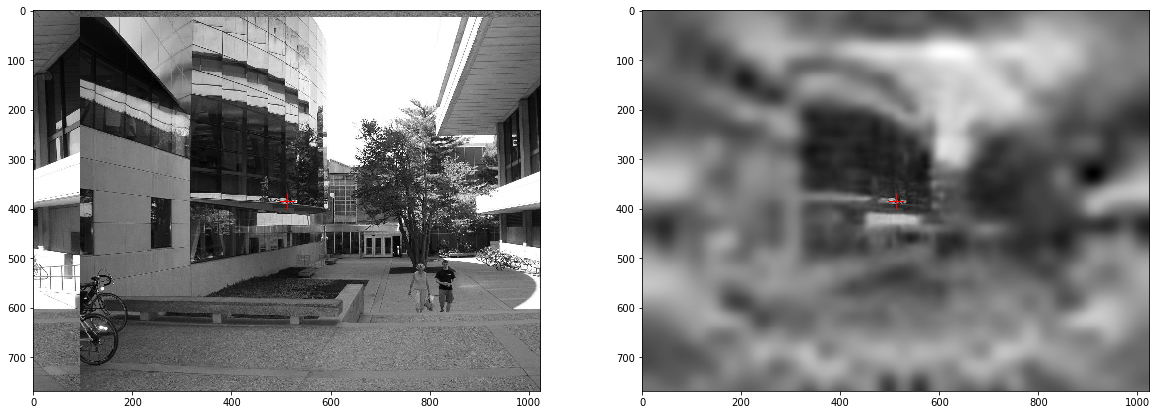

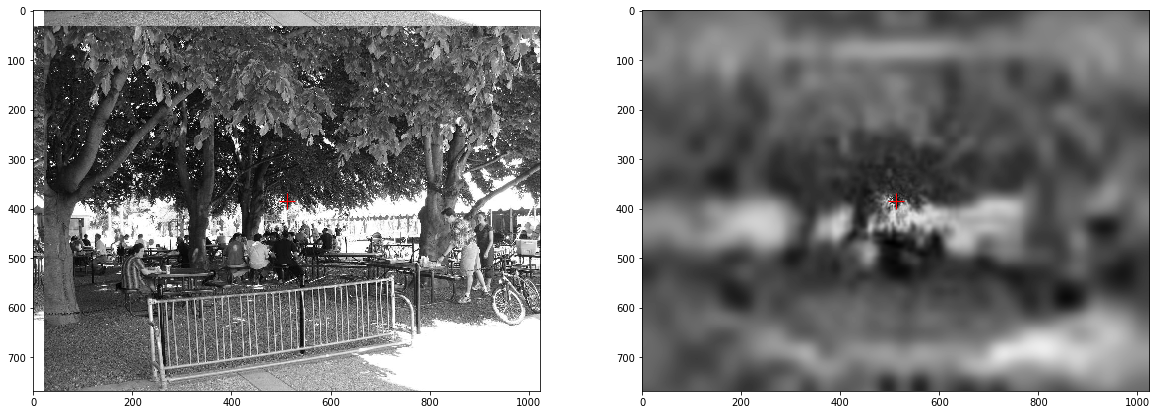

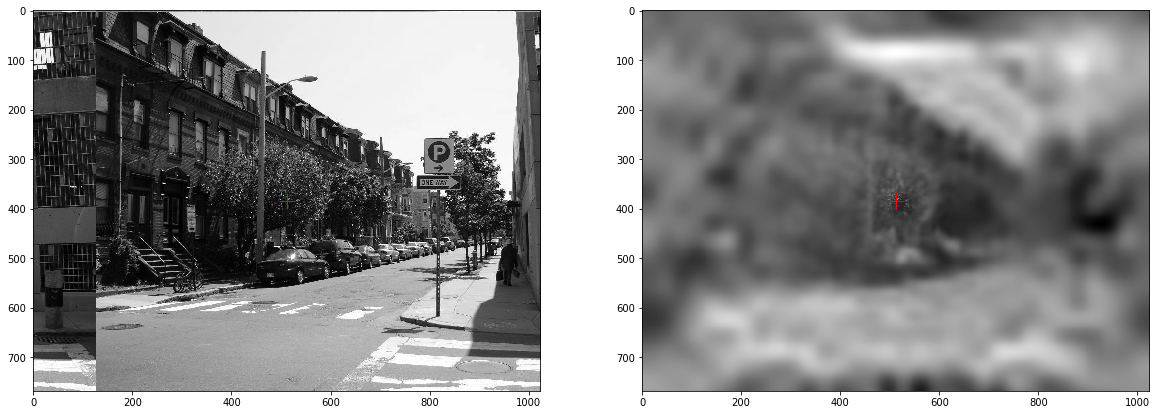

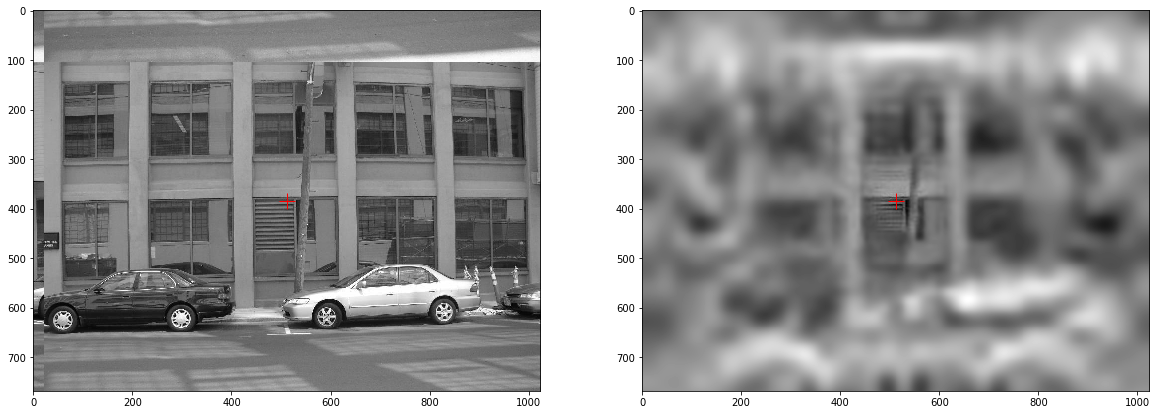

In [59]:
for i_batch in range(N_batch):
    fig, axs = plt.subplots(1, 2, figsize=(20, 20))
    for ax, img in zip(axs, [target[i_batch, 0, :, :], img_rec[i_batch, 0, :, :]]):
        ax.imshow(img.numpy(), cmap='gray')
        ax.plot([N_Y//2], [N_X//2], 'r+', ms=16);


## Estimating running time in realistic conditions (no downscaling, ds=1)

In [45]:
%%timeit
K = get_K()

148 ms ± 2.21 ms per loop (mean ± std. dev. of 7 runs, 10 loops each)


In [46]:
N_batch = 128
K = get_K()
test_dataloader = get_dataloader(K, N_batch, ds=1, verbose=False)
for batch_idx, (target, out) in enumerate(test_dataloader):
    print(batch_idx, target.shape, out.shape)
    N_X, N_Y = target.shape[-2:]
    img_crop = cropped_pyramid(target)
    out = torch.tensordot(img_crop, K,  dims=2)
    img_rec = inverse_pyramid(out, K, N_X, N_Y)

0 torch.Size([128, 1, 768, 1024]) torch.Size([128, 6, 2, 12, 12, 2])


In [47]:
%%timeit
img_crop = cropped_pyramid(target)

2.66 s ± 115 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)


In [48]:
%%timeit
out = torch.tensordot(img_crop, K,  dims=2)

2.15 ms ± 267 µs per loop (mean ± std. dev. of 7 runs, 100 loops each)


In [49]:
out = torch.tensordot(img_crop, K,  dims=2)

In [50]:
%%timeit
img_rec = inverse_pyramid(out, K, N_X, N_Y)

2.01 s ± 26.6 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)
